In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from core_dl.get_host_name import get_host_name

/home/luweiy/code/squeezer/dbg/dbg_common.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### network

In [3]:
from exp.scene_sq_unified_ptsel_box import *
from pipeline.pose_util import estimate_pose

In [4]:
exp = 'exp_dual_matcher'
hostname = get_host_name()
params = TrainParameters(os.path.join('../exp_config/%s.json' % exp))
params.DEBUG = True
params.DEV_IDS = [0, 0]

params.AUX_CFG_DICT['dist_kernel_rbf_sigma'] = 1.0
params.AUX_CFG_DICT['qp_solver'] = 'cvxpy'
params.AUX_CFG_DICT['qp_compression_ratio'] = 0.1
params.AUX_CFG_DICT['qp_distinctiveness_weight'] = -2.30258
params.AUX_CFG_DICT['qp_num_pts'] = 100
params.AUX_CFG_DICT['sqz_aggre_method'] = 'mean'

[TrainParameters] Load Train parameters from ../exp_config/exp_dual_matcher.json


In [5]:
# define the quantilizer
dm = 128
params.AUX_CFG_DICT['reduce_dim_list'] = [256, dm, dm]
params.AUX_CFG_DICT['increase_dim_list'] = [dm, 256, 256]

In [6]:
params.CKPT_DICT['quantizater'] = LOG_DIR_04s / 'Oct16_19-24-22_docker_soft_quant_encoder/ckpt/epoch_9.ckpt'
params.CKPT_DICT['instance'] = 'Nov07_19-43-08_docker_qp_rndsel256_learnkernel10_pnploss/ckpt/iter_38000.ckpt'

[11/20/2021 21:57:22 INFO] Connected (version 2.0, client OpenSSH_8.2p1)
[11/20/2021 21:57:22 INFO] Authentication (publickey) successful!
[11/20/2021 21:57:23 INFO] [chan 0] Opened sftp connection (server version 3)
[11/20/2021 21:57:25 INFO] [chan 0] sftp session closed.
[11/20/2021 21:57:25 INFO] Connected (version 2.0, client OpenSSH_8.2p1)
[11/20/2021 21:57:25 INFO] Authentication (publickey) successful!
[11/20/2021 21:57:25 INFO] [chan 0] Opened sftp connection (server version 3)
[11/20/2021 21:57:27 INFO] [chan 0] sftp session closed.


In [7]:
train_box = SceneSQPTSelBox(params)
train_box.load_from(params.CKPT_DICT)
train_box.eval()

********************************************[ Network: stg1_binarized_loss ]********************************************
[ExprCtx] Set temporary output dir: /tmp/squeezer/dbg
Loaded SuperGlue model ("outdoor" weights)
NOTE: Solver Type: cvxpy
[SceneSQPTSelBox] NOTE: The dimension of feature is reduced to 128
[SuperGlueGNNMatcher] NOTE: inited with external weights
Network information, N/A
NOTE: Disabled: automatic assigning device
NOTE: Disabled: pl's automatic optimizer
[SceneSQPTSelBox] NOTE: model loaded from /tmp/ckpts/iter_38000.ckpt
[SceneSQPTSelBox] NOTE: [quantizater] overloaded from /tmp/ckpts/epoch_9.ckpt
[SceneSQPTSelBox] NOTE: Setting Lightning Model to eval model.
NOTE: Move <class 'matcher.superglue_matcher.SuperGlueMatcher'> to device: 0
NOTE: Move <class 'net.scene_mfuser_sq.SceneSqueezerWithTestQueries'> to device: 0
NOTE: Move <class 'net.qp_ptsel_transformer.PointSelection'> to device: 0
NOTE: Move <class 'matcher.superglue_gnn_matcher.SuperGlueGNNMatcher'> to device

In [8]:
# soft-quant
qtz = train_box.quantizater
dsq = train_box.quantizater.quantizate

### config dataset

In [9]:
from dataset.cambridge.data_source import CambridgeDataSource

In [10]:
from dataset.cambridge.sampling_utils import *

In [11]:
# dataset_name = 'cambridge_kings_college'
# dataset_name = 'cambridge_old_hospital'
dataset_name = 'cambridge_st_marys_church'
# dataset_name = 'cambridge_facade'

with open('../dataset/config/data.%s.json' % get_host_name()) as f:
    dataset_cfg = json.load(f)[dataset_name]

ds = CambridgeDataSource(dataset_cfg)

[CambridgeDataSource] Loading HLOC scene model:   0%|          | 0/2 [00:00<?, ?it/s]

[CambridgeDataSource] Loaded reconstruction model from /mnt/Exp_fast/dataset/cambridge/StMarysChurch/hloc_output with SfM: sfm_superpoint+superglue
[CambridgeDataSource] Total 0 query clips, 0 scene reference sub-graphs from 2 scenes


In [12]:
m_db = ds.trj_dbs['mapping']
q_db = ds.trj_dbs['query']
m_names = list(m_db.img_name2id.keys())
q_names = list(q_db.img_name2id.keys())

### build co-visible cluster

In [29]:
# roots = find_roots(ds, 'mapping', ref_subgraph_spatial_dist=6.0, ref_subgraph_rot_dist=45, verbose=True)
# roots = filter_ref_subgraph(ds, 'mapping', roots, ref_subgraph_spatial_dist=6.0, ref_subgraph_rot_dist=45)
# # roots = [r for r in roots]

In [13]:
v_dist = get_visual_dist_matrix(ds, 'mapping', m_names)

compute co-visible observations:   0%|          | 0/1487 [00:00<?, ?it/s]

In [14]:
num_sub_clusters, sub_clusters = get_h_clusters(np.log(1/(v_dist + 1e-6)), dist_thres=80)
print('Filtered by co-visible thres: %d' % num_sub_clusters)

Filtered by co-visible thres: 52


In [15]:
cl_roots = []
for cl in range(num_sub_clusters):
    cl_idx = np.where(cl == sub_clusters)[0]
    cl_roots.append([m_names[c] for c in cl_idx])

In [16]:
# build subgraphs --------------------------------------------------------------------------------------------------
refs = build_ref_subgraphs(ds, cl_roots, 'mapping', 
                           max_frames_per_graph=18,
                           ref_subgraph_spatial_dist=6.0, ref_subgraph_rot_dist=60, 
                           verbose=True)

Constructing sub_graphs:   0%|          | 0/52 [00:00<?, ?it/s]

Total 52 subgraphs


## squeeze

In [17]:
def get_kernels_(box: SceneSQPTSelBox, v_info, anchor_info, l_rbf=1.0, d_rbf=1.0):

    v_metas, v_pt2d, _ = dict2obs(v_info)
    ar_metas, ar_pt2d, ar_pt3d = dict2obs(anchor_info)

    with torch.cuda.device(box.device_of(box.sqz)) as _, torch.no_grad() as _:
        cur_dev = torch.cuda.current_device()
        
        (log_var, kernel_feats), (r_xyz, r_feats), interm = box.sqz.forward(
            v_metas, v_pt2d, ar_metas, ar_pt2d, ar_pt3d
        )
        if log_var is None:
            return None, None, None, None
        input_feats = interm['in_feats'].contiguous()
        B, M, _ = input_feats.shape
        dist_score = torch.exp(- log_var).to(cur_dev).view(B, M, 1)
#         input_feats = torch.cat([input_feats, dist_score], dim=-1).contiguous()
        
        dist_score = dist_score.view(B, M)
        
        Kl, _ = train_box.pt_sel.get_kernel(ar_pt3d.xyz, input_feats, l_rbf)
        Kd = train_box.pt_sel.get_distance_kernel(ar_pt3d.xyz)
        
    return dist_score.view(M), Kd.view(M, M), Kl.view(M, M), r_xyz, r_feats

In [18]:
from pipeline.iter_ref_subgraphs import iter_ref_loader
from pipeline.squeezer import *
from core_math.cvxpy_qp_solver import CVXPY_QP
from core_math.smo_qp_solver import SMO_QP
from timeit import default_timer as timer

refs_loader = iter_ref_loader(refs, ds, va_ratio=(0.6, 0.4), anchor_sampling_method='greedy', num_workers=0)


In [20]:
sqz_xyz, sqz_feats, sqz_raw_feats = dict(), dict(), dict()

In [21]:
for r, rf in sqz_feats.items():
    print(rf.shape)

In [91]:
v = 0.22
rbf_sigma = 1.0
train_box.pt_sel.learnt_kernel_rbf_sigma = 1.0

# tao = torch.ones(1, device=train_box.pt_sel.lambda_weight.device) * 0.01
tao = train_box.pt_sel.get_tao()
qp_solver = SMO_QP(compression_ratio=v, num_iters=20000)
MIN_COMPRESSED_POINTS = 100

time_sqz_net = 0
time_qp = 0

i = 0
for ref_sample in tqdm(refs_loader):
    fq_imgs, fq_info, rp_imgs, rp_info = ref_sample
    ref_id = i
    num_pts = rp_info['pt3d'].shape[1]
    
    st = timer()
    d, Kd, Kl, r_xyz, r_feats = get_kernels_(train_box, fq_info, rp_info, rbf_sigma)
    if d is None:
        continue
    end = timer()
    time_sqz_net += (end - st)
    
    r_before = r_xyz.shape[0]
    r_compressed = int(v * r_before)
    if r_compressed < MIN_COMPRESSED_POINTS:
        qp_solver.compression_ratio = MIN_COMPRESSED_POINTS / r_before
    else:
        qp_solver.compression_ratio = v
    
    # solve by QP
    st = timer()
    alpha = alpha_by_qp(qp_solver, d, 0.5 * (Kd + Kl), 0.1, max_sample_points=-1, sample_method='score', use_cvxpy=(num_pts < 800))
    end = timer()
    time_qp += (end - st)
#     alpha = alpha_by_qp(qp_solver, d, Kd, tao * 3, max_sample_points=-1, sample_method='score', use_cvxpy=(num_pts < 800))

    # filtering
    if num_pts > 100:
        sel_ref_idx = torch.where(alpha > 0.1)[0]
        
        # random
#         sel_ref_idx = torch.from_numpy(np.random.choice(r_before, size=sel_ref_idx.shape[0], replace=False))
#         sel_ref_idx = torch.argsort(d, descending=True)[:sel_ref_idx.shape[0]]
    
        r_xyz = r_xyz[sel_ref_idx]
        r_feats = r_feats[:, :, sel_ref_idx]
    
    sqz_raw_feats[ref_id] = r_feats.clone()
    
    # encode to uint8
    _, r_feats_quats, _ = qtz.encode(r_feats)

    sqz_xyz[ref_id] = r_xyz.cpu()
    sqz_feats[ref_id] = r_feats_quats.cpu()
    print('%d, Ref Points:  %d -> %d' % (ref_id, num_pts, r_xyz.shape[0]))
    
    i += 1
#     break

  0%|          | 0/52 [00:00<?, ?it/s]

0, Ref Points:  5129 -> 1192
1, Ref Points:  4728 -> 1125
2, Ref Points:  6345 -> 1477
3, Ref Points:  4764 -> 1103
4, Ref Points:  8342 -> 1873
5, Ref Points:  7861 -> 1749
6, Ref Points:  8312 -> 1866
7, Ref Points:  7824 -> 1792
8, Ref Points:  9400 -> 2098
9, Ref Points:  9654 -> 2158
10, Ref Points:  8305 -> 1859
11, Ref Points:  8857 -> 1988
12, Ref Points:  7654 -> 1729
13, Ref Points:  9629 -> 2140
14, Ref Points:  9864 -> 2188
15, Ref Points:  9030 -> 2014
16, Ref Points:  4099 -> 999
17, Ref Points:  9417 -> 2111
18, Ref Points:  8033 -> 1796
19, Ref Points:  8306 -> 1866
20, Ref Points:  6765 -> 1539
21, Ref Points:  3544 -> 833
22, Ref Points:  5273 -> 1201
23, Ref Points:  7370 -> 1667
24, Ref Points:  8409 -> 1884
25, Ref Points:  6751 -> 1536
26, Ref Points:  2586 -> 702
27, Ref Points:  8385 -> 1873
28, Ref Points:  7388 -> 1658
29, Ref Points:  9014 -> 1997
30, Ref Points:  9520 -> 2116
31, Ref Points:  8593 -> 1922
32, Ref Points:  10238 -> 2274
33, Ref Points:  4734 

In [92]:
# count total points
total_pts = 0
for _, r_xyz in sqz_xyz.items():
    if len(r_xyz) > 0:
        total_pts += r_xyz.shape[0]
print(f"Total {total_pts} points")

pt_size = (140 * total_pts) / 1024

total_size = pt_size + len(sqz_xyz)
print('Size: %d KB (%.2f MB)' % (total_size, total_size / 1024.0))

Total 88265 points
Size: 12119 KB (11.84 MB)


### localize them! (aggregate 2D-3D matches, like HLoc)

In [81]:
from pipeline.retrieval_db import RetrievalDB

ref_db = RetrievalDB(encoder_ckpt_path='/mnt/Exp/pretrain/Resnet-101-AP-GeM-state-dict.pt', 
                     dev_id=params.DEV_IDS[0], 
                     preprocess_func='default')

In [82]:
i = 0
for ref in tqdm(refs):
    root_img = ds.get_images(ref['nodes'][0:1], to_tensor=False)[0]
    with torch.no_grad():
        ref_db.add_to_db(i, ref_db.encode(root_img))
    i+= 1

  0%|          | 0/52 [00:00<?, ?it/s]

In [93]:
import pycolmap
from core_math.transfom import quaternion_matrix

def estimate_pose_(ds, q_name, q_uv, ref_xyz, thresh=12):
    if isinstance(q_uv, torch.Tensor):
        q_uv = asnumpy(q_uv)
    if isinstance(ref_xyz, torch.Tensor):
        ref_xyz = asnumpy(ref_xyz)

    q_raw = ds.trj_dbs['query'].get_cam_raw_params([q_name])[0]
    q_cam_type, q_frame_dim, q_params = q_raw['cam_type'], q_raw['cam_params'][:2], q_raw['cam_params'][2:]

    cfg = {
        'model': 'SIMPLE_PINHOLE',
        'width': int(q_frame_dim[1]),
        'height': int(q_frame_dim[0]),
        'params': np.asarray(q_params)[:3].astype(np.float64),
    }
    ret = pycolmap.absolute_pose_estimation(q_uv.astype(np.float64) + 0.5, ref_xyz.astype(np.float64), cfg, thresh)
    
    if ret['success'] is False:
        return None, None
    else:
        Tcw = np.eye(4, dtype=np.float32)
        Tcw[:3, :3] = quaternion_matrix(ret['qvec'])[:3, :3]
        Tcw[:3, 3] = ret['tvec'].ravel()
        inliers = np.asarray(ret['inliers'])
        
        return Tcw, inliers

In [94]:
cfg_top_k = 15
cfg_pnp_thres = 12

In [95]:
# inlier_ratios, trans_errs, rotdeg_errs = [], [], []
ret = dict()

q_i = 0

for q_name in tqdm(q_names):
    
    
    # extract query infos
    q_pos2d = ds.retrieval_2D([q_name], scene='query')
    q_dim, q_K, q_gt_Tcw = ds.get_cam_params([q_name], scene='query')
    q_metas = ClipMeta(dataset_name, [q_name], q_gt_Tcw, 'query', q_K, q_dim, [torch.zeros(2)])
    
    # find the nearest references
    q_img = ds.get_images([q_name], to_tensor=False)
    nearest_res = ref_db.search_db(ref_db.encode(q_img[0]))
    
    # register
    with torch.cuda.device(train_box.device_of(train_box.q2r)) as _, torch.no_grad() as _:
        q_feats = encode_sp_feats(train_box.q2r, q_metas, q_pos2d, split=False)

    with torch.cuda.device(train_box.device_of(train_box.dual_matcher)) as _, torch.no_grad() as _:
        cur_dev = torch.cuda.current_device()
   
        q_aggr_uv, r_aggr_xyz = [], []
        for rc_idx in nearest_res[:cfg_top_k]:
            
            if rc_idx not in sqz_xyz:
#                 print('ignored')
                continue

            rc_xyz = sqz_xyz[rc_idx]
#             rc_uint8_feats = sqz_feats[rc_idx].to(cur_dev)

            # decode the uint8 feats
#             rc_feats = qtz.decode(dsq.recover(rc_uint8_feats.float()))
            rc_feats = sqz_raw_feats[rc_idx].to(cur_dev)

            # match
            r2q_score = train_box.dual_matcher.get_score(rc_feats, q_feats.to(cur_dev), optimal_transport=True)
            r2q_matches = train_box.dual_matcher.get_matches(r2q_score, optimal_transport=False)['matches0'][0].cpu()

            r2q_matches = torch.cat([torch.arange(0, rc_xyz.shape[0]).int().unsqueeze(-1),
                                 r2q_matches.int().unsqueeze(-1)], dim=-1).long()    

            # localize
            r2q_matches_v = r2q_matches[torch.where(r2q_matches[:, 1] > 0)[0]]
            ref_sel_xyz, q_sel_uv = corres_pos_from_pairs(rc_xyz.cpu(), q_pos2d.uv[0].cpu(), r2q_matches_v.cpu())

            # localize
            pred_Tcw, inliers = estimate_pose_(ds, q_name, q_sel_uv, ref_sel_xyz, thresh=cfg_pnp_thres)
#             print(rc_idx, inliers)
            if inliers is not None:
                 
                inlier_ratio = inliers.sum() / inliers.shape[0]
                
                if inliers.sum() > 10:
#                     if inlier_ratio > 0.6 and inliers.sum() > 4:
                    q_aggr_uv.append(q_sel_uv[inliers])
                    r_aggr_xyz.append(ref_sel_xyz[inliers])
                    
                # visualize matches
#                 r_info = refs[rc_idx]
#                 r_vis_names = [r for r in r_info['nodes']]
#                 r_vis_imgs = ds.get_images(r_vis_names, to_tensor=False)
#                 r_dims, r_Ks, r_Tcws = ds.get_cam_params(r_vis_names)
                
#                 prj_kpt_pos2ds = []
#                 for r_K, r_Tcw, r_dim in zip(r_Ks, r_Tcws, r_dims):
#                     prj_kpt_pos2d, prj_kpt_depth = cam_opt_gpu.reproject(torch.from_numpy(r_Tcw), torch.from_numpy(r_K), ref_sel_xyz)
#                     valid_mask = cam_opt_gpu.is_in_t(prj_kpt_pos2d, prj_kpt_depth, r_dim)
#                     prj_kpt_pos2d = prj_kpt_pos2d[torch.where(valid_mask == True)[0]]
#                     prj_kpt_pos2ds.append(asnumpy(prj_kpt_pos2d))

#                 plot_images(r_vis_imgs)
#                 plot_keypoints(prj_kpt_pos2ds)                   
            
        if len(q_aggr_uv) > 0:
            q_aggr_uv = torch.cat(q_aggr_uv, dim=0)
            r_aggr_xyz = torch.cat(r_aggr_xyz, dim=0)

            pred_Tcw, inliers = estimate_pose_(ds, q_name, q_aggr_uv, r_aggr_xyz, thresh=cfg_pnp_thres)
            inlier_ratio = inliers.sum() / inliers.shape[0]
            num_inliers = inliers.sum()
            
            # measure the errs
            if inlier_ratio > 0.1:
                rel_dist_err, rel_rot_err = rel_distance(pred_Tcw, q_gt_Tcw[0]), rel_R_deg(pred_Tcw, q_gt_Tcw[0])
            else:
                inlier_ratio, num_inliers, rel_dist_err, rel_rot_err = 0, 0, 10, 180
        else:
            inlier_ratio, num_inliers, rel_dist_err, rel_rot_err = 0, 0, 10, 180

        # gather errs
        ret[q_name] = (inlier_ratio, num_inliers, rel_dist_err, rel_rot_err)
        print('q:%s: inlier_ratio: %.2f (%d), trans_err: %.4f, rot_err: %.4f' % (q_name, inlier_ratio, num_inliers, rel_dist_err, rel_rot_err))
    
    q_i += 1

  0%|          | 0/530 [00:00<?, ?it/s]

q:seq13/frame00155.png: inlier_ratio: 0.94 (322), trans_err: 0.1037, rot_err: 0.4878
q:seq13/frame00156.png: inlier_ratio: 0.94 (257), trans_err: 0.2540, rot_err: 0.2407
q:seq13/frame00157.png: inlier_ratio: 0.96 (354), trans_err: 0.1785, rot_err: 0.3039
q:seq13/frame00158.png: inlier_ratio: 0.98 (424), trans_err: 0.1209, rot_err: 0.2307
q:seq13/frame00159.png: inlier_ratio: 0.99 (500), trans_err: 0.0405, rot_err: 0.2037
q:seq13/frame00160.png: inlier_ratio: 0.99 (568), trans_err: 0.0454, rot_err: 0.2017
q:seq13/frame00161.png: inlier_ratio: 0.99 (640), trans_err: 0.0850, rot_err: 0.3090
q:seq13/frame00162.png: inlier_ratio: 0.99 (702), trans_err: 0.0584, rot_err: 0.2273
q:seq13/frame00163.png: inlier_ratio: 0.97 (704), trans_err: 0.0836, rot_err: 0.2203
q:seq13/frame00164.png: inlier_ratio: 0.98 (727), trans_err: 0.0294, rot_err: 0.1153
q:seq13/frame00165.png: inlier_ratio: 0.98 (672), trans_err: 0.1262, rot_err: 0.4334
q:seq13/frame00166.png: inlier_ratio: 0.98 (694), trans_err: 0.08

### Measure

In [96]:
inlier_ratios, trans_errs, rotdeg_errs = [], [], []
for q_name in ret.keys():
    inlier_ratio, num_inliers, rel_dist_err, rel_rot_err = ret[q_name]
    inlier_ratios += [inlier_ratio]
    trans_errs += [rel_dist_err]
    rotdeg_errs += [rel_rot_err]
    
inlier_ratios = np.asarray(inlier_ratios)
trans_errs, rotdeg_errs = np.asarray(trans_errs), np.asarray(rotdeg_errs)

In [97]:
print('Median Trans: %.2f, Median Rot: %.2f' % (np.median(trans_errs), np.median(rotdeg_errs)))

Median Trans: 0.12, Median Rot: 0.27


Text(0.5, 1.0, 'Rot Err (deg)')

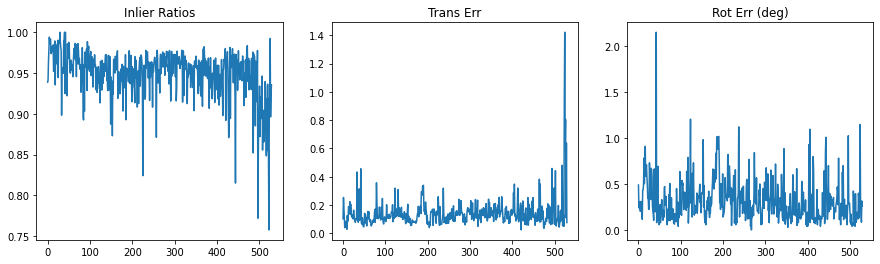

In [98]:
# plot
x_axis = np.arange(inlier_ratios.shape[0])
figs, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].plot(x_axis, inlier_ratios)
ax[0].set_title('Inlier Ratios')

ax[1].plot(x_axis, trans_errs)
ax[1].set_title('Trans Err')

ax[2].plot(x_axis, rotdeg_errs)
ax[2].set_title('Rot Err (deg)')


In [100]:
# count the ratio under (0.25m, 2deg)
t_thres = 0.5
r_thres = 5

true_positives = 0
for t_err, r_err in zip(trans_errs, rotdeg_errs):
    if t_err < t_thres and r_err < r_thres:
        true_positives += 1
print('Under (%.2f, %.2f): %f' % (t_thres, r_thres, true_positives / trans_errs.shape[0]))

Under (0.50, 5.00): 0.990566


In [ ]:
# dist_thres=50, size=6.03mb, ref_graphs: 270, acc=0.898113, 0.990566, Median Trans:0.14, Median Rot: 0.30
# dist_thres=60, size=2.99mb, ref_graphs: 133, acc=0.892453, 0.984906, Median Trans: 0.14, Median Rot: 0.32
# dist_thres=70, size=1.68mb, ref_graphs: 72, acc=0.866038, 0.981132, Median Trans: 0.15, Median Rot: 0.36
# dist_thres=80, size=1.18mb, ref_graphs: 52, acc=0.869811, 0.977358, Median Trans: 0.15, Median Rot: 0.34
# dist_thres=90, size=0.67mb, ref_graphs: 30, acc=0.807547, 0.971698, Median Trans: 0.15, Median Rot: 0.38
# dist_thres=１00, size=0.51mb, ref_graphs: 22, acc=0.762264, 0.937736, Median Trans: 0.17, Median Rot: 0.42
# dist_thres=１20, size=0.38mb, ref_graphs: 16, acc=0.705660, 0.903, Median Trans: 0.18, Median Rot: 0.48

In [ ]:
# dist_thres=50, size=307.25 MB, ref_graphs: 270, acc=0.950943, 0.996226, Median Trans:0.11, Median Rot: 0.24  # uncompressed (Hloc)
# dist_thres=80, size=1.18mb, ref_graphs: 52, acc=0.869811, 0.977358, Median Trans: 0.15, Median Rot: 0.34  # uncompressed (Hloc), 1.5%
# dist_thres=80, size=1.93MB, ref_graphs: 52, acc=0.913208, 0.988679, Median Trans: 0.13, Median Rot: 0.29  # uncompressed (Hloc), 3%
# dist_thres=80, size=3.51MB, ref_graphs: 52, acc=0.930189, 0.990566, Median Trans: 0.13, Median Rot: 0.28  # uncompressed (Hloc), 6%
# dist_thres=80, size=6.63MB, ref_graphs: 52, acc=0.941509, 0.990566, Median Trans: 0.13, Median Rot: 0.28  # uncompressed (Hloc), 12%
# dist_thres=80, size=9.75MB, ref_graphs: 52, acc=0.945283, 0.992453, Median Trans: 0.12, Median Rot: 0.27  # uncompressed (Hloc), 18%